In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from glob import glob
import os
import TOC_functions
%matplotlib widget

In [2]:
root_folder = os.path.expanduser('C:/Users/ica/OneDrive - Plymouth Marine Laboratory/vscode/TOC_analysis/data/2025/01')  # yourpath
picarro_df = TOC_functions.merge_picarro_files(root_folder)
picarro_df = TOC_functions.qc(picarro_df)


In [3]:
# filter by time

start_time = datetime.datetime(2025, 1, 17, 16, 5, 0)
end_time = datetime.datetime(2025, 1, 17, 16, 15, 0)

In [4]:
picarro_df.set_index('datetime', inplace=True)

df = picarro_df.loc[start_time:end_time]

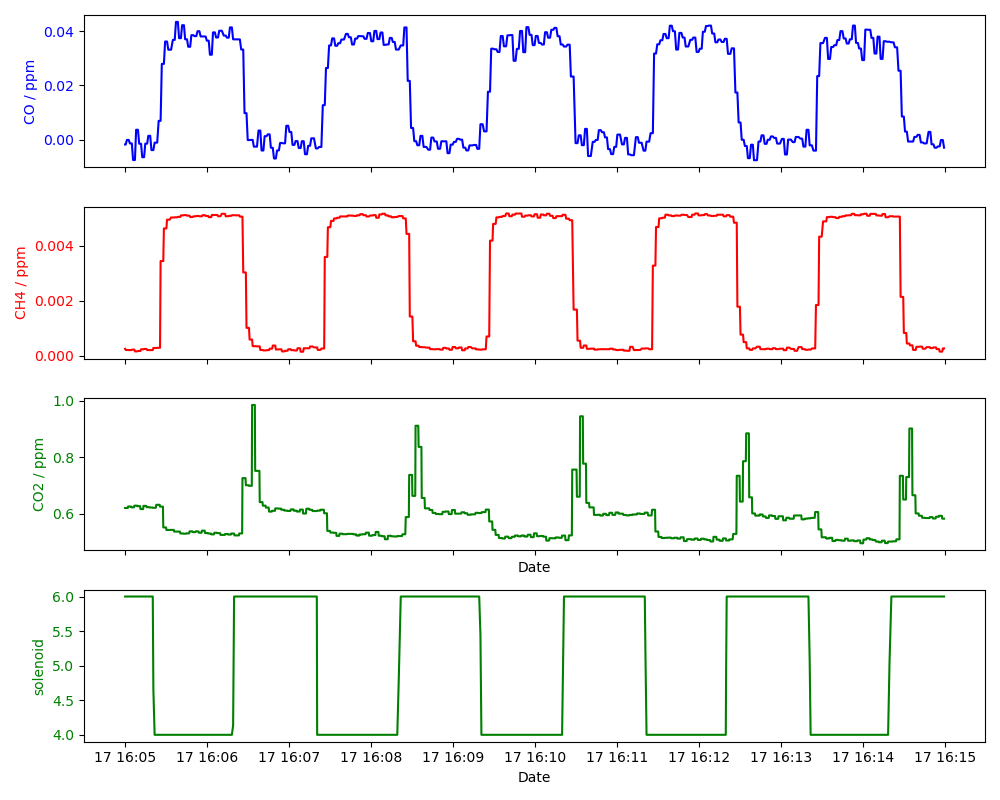

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 8))

# Plot for CO
ax1.plot(df.index, df.CO, label='CO / ppm', color='blue')
ax1.set_ylabel('CO / ppm', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot for CH4
ax2.plot(df.index, df.CH4, label='CH4 / ppm', color='red')
ax2.set_ylabel('CH4 / ppm', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot for CO2
ax3.plot(df.index, df.CO2, label='CO2 / ppm', color='green')
ax3.set_xlabel('Date')
ax3.set_ylabel('CO2 / ppm', color='green')
ax3.tick_params(axis='y', labelcolor='green')

ax4.plot(df.index, df.solenoid_valves, label='', color='green')
ax4.set_xlabel('Date')
ax4.set_ylabel('solenoid', color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [7]:

df = TOC_functions.qc(df)



c:\Users\ica\OneDrive - Plymouth Marine Laboratory\vscode\TOC_analysis\TOC_functions.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CO2_corrected'] = (df['CO2_dry'] + 0.63141) / 0.99357
c:\Users\ica\OneDrive - Plymouth Marine Laboratory\vscode\TOC_analysis\TOC_functions.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CH4_corrected'] = df['CH4_dry'] * (2.024799 / 2.0238)


In [11]:

# lists for storing averages
avg_times = []
avg_co2_ambient = []
avg_co2_catalyst = []
avg_ch4_ambient = []
avg_ch4_catalyst = []
avg_co_ambient = []
avg_co_catalyst = []

# detect for valve changes
valve_change = df[(df['solenoid_valves'] !=6.0) & (df['solenoid_valves'] != 4.0)]  # valve =2 is catalyst
                                                                                    # valve = 0 is ambient

# averages before valve changes
for i in valve_change.index:
    #  time window (25s before valve change, ending 2s before)
    end_time = i - pd.Timedelta(seconds=2)
    start_time = end_time - pd.Timedelta(seconds=42)
    
    # get data in the main df within time window
    window_df = df[(df.index > start_time) & (df.index < end_time)]
    
    # averages
    avg_co2 = window_df['CO2_corrected'].mean()
    avg_ch4 = window_df['CH4_corrected'].mean()
    avg_co = window_df['CO'].mean()
    avg_valve = window_df['solenoid_valves'].mean()
    avg_time_val = window_df.index.mean()
    avg_times.append(avg_time_val)

    # sort appropriate lists based on valve state
    if avg_valve == 6.0:  # catalyst
        avg_co2_catalyst.append(avg_co2)
        avg_ch4_catalyst.append(avg_ch4)
        avg_co_catalyst.append(avg_co)
        avg_co2_ambient.append(np.nan)
        avg_ch4_ambient.append(np.nan)
        avg_co_ambient.append(np.nan)
    elif avg_valve == 4.0:  # ambient
        avg_co2_ambient.append(avg_co2)
        avg_ch4_ambient.append(avg_ch4)
        avg_co_ambient.append(avg_co)
        avg_co2_catalyst.append(np.nan)
        avg_ch4_catalyst.append(np.nan)
        avg_co_catalyst.append(np.nan)

# create results df
TOC_df = pd.DataFrame({
    'datetime': avg_times,
    'avg_co2_ambient': avg_co2_ambient,
    'avg_ch4_ambient': avg_ch4_ambient,
    'avg_co_ambient': avg_co_ambient,
    'avg_co2_catalyst': avg_co2_catalyst,
    'avg_ch4_catalyst': avg_ch4_catalyst,
    'avg_co_catalyst': avg_co_catalyst
})


In [23]:
# TOC averages
TOC_df_blank =TOC_functions.TOC_df_blank(df)
# calculate final TOC
TOC_df =TOC_df[:-1]
toc = TOC_functions.calculate_toc(TOC_df)


AttributeError: 'function' object has no attribute 'set_index'

In [ ]:
plt.figure()
plt.plot(toc.index, toc['TOC'])
plt.ylabel('TOC / ppm')
plt.xlabel('Date (Day Hour:Muinute)')
plt.show()

In [ ]:
toc.mean()